# Кластеризация

До этого мы рассматривали методы обучения с учителем, то есть задачи, в которых изначально есть размеченная обучающая выборка данных с известными ответами.

Теперь мы рассмотрим _обучение без учителя (unsupervised learning)_ - то есть такое семейство методов, где в роли обучающей выборки выступает просто набор объектов $x_{1},...,x_{l}$, и он же выступает в роли тестовой выборки, а задача состоит в проставлении меток $y_{1},...,y_{l}$ так, что бы объекты с одной и той же меткой были "похожи", а с разными - нет. То есть все объекты в пространстве признаков нужно разделить на группы, найти структуру в данных.

Это и называется _кластеризацией_.

По-простому задачу кластеризации можно сформулировать так: имеется множество точек, которые скапливаются в сгустки, нужно найти возможность относить точки к тому или иному сгустку и предсказывать, в какой сгусток попадет новая точка.

## K-means

Одним из самых простых и популярных алгоритмов кластеризации является алгоритм _K-means (K-средних)_. Заключается он в следующих шагах:

1. Выбрать количество кластеров $k$, на которые будут делиться данные.

2. Случайным образом выбрать в пространстве данных $k$ точек $c_{k}$ (центроидов) - центров будущих кластеров.

3. Для каждой точки из выборки посчитать, к какому из центроидов она ближе.

4. Переместить каждый центроид в центр выборки, отнесенной к этому центроиду, определив его как среднее арифметическое всех точек кластера:

$$c_{k} = \frac{\sum_{i=1}^{l}[a(x_{i})=k]x_{i}}{\sum_{i=1}^{l}[a(x_{i}) = k]}.$$


5. Повторить шаги 4-5 до сходимости алгоритма (обычно это оценивается по величине смещения центроида после каждого шага - сходимость означает непревышение смещения какого-то заданного значения).

Результат работы алгоритма значительно зависит от начального выбора центроидов. Существует много методик их выбора, наиболее удачным из которых считается k-means++. Он заключается в последовательном выборе начальных приближений так, что вероятность выбрать в качестве центроида следующую точку пропорциональна квадрату расстояния от нее до ближайшего центроида.

Проблемой метода является необходимость знать число кластеров, на которые будет делиться выборка. В случае, когда это число неизвестно, вариантом может быть последовательная кластеризация на разное число кластеров с последующим анализом качества работы алгоритма, например, по сумме квадратов внутрикластерных расстояний $$\sum_{k=1}^{K}\sum_{i \in C_{k}}\rho(x_{i}, c_{k})^{2}$$ - выбирается такое число кластеров, начиная с которого при увеличении количества кластеров функционал падает незначительно.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

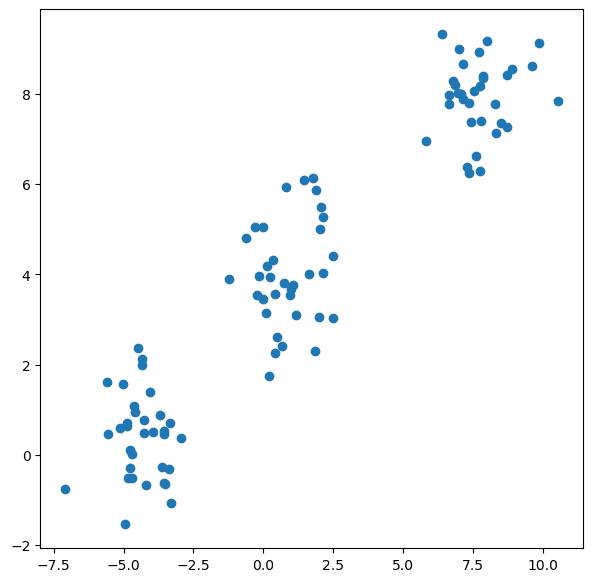

In [2]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=100, random_state=3)

plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

plt.show()

In [3]:
def e_metrics(x, y):

    distance = 0
    for i in range(len(x)):
        distance += np.square(x[i] - y[i])

    return np.sqrt(distance)

In [4]:
def kmeans(data, k, max_iterations, min_distance):

    centroids = [data[i] for i in range(k)] # инициализируем центроиды как первые k элементов датасета

    for _ in range(max_iterations):

        classes = {i: [] for i in range(k)} # Создадим словарь для классификации

        # классифицируем объекты по центроидам
        for x in data:

            distances = [e_metrics(x, centroid) for centroid in centroids] # определим расстояния от объекта до каждого центроида

            classification = distances.index(min(distances)) # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classes[classification].append(x)

        old_centroids = centroids.copy() # сохраним предыдущие центроиды в отдельный список для последующего сравнения с новыми

        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)

        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False

        # если все смещения меньше минимального, останавливаем алгоритм
        if optimal:
            break

    return old_centroids, classes

In [5]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b']

    plt.figure(figsize=(7,7))

    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')

    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])

    plt.show()

In [6]:
# определим максимальное количество итераций
max_iterations = 1

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

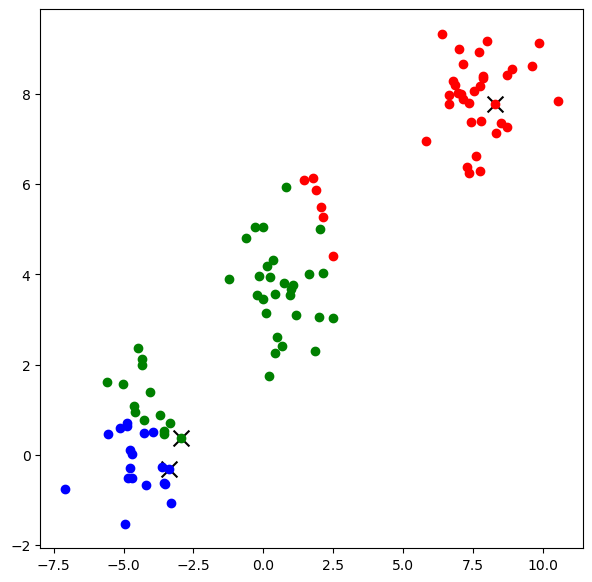

In [7]:
centroids, clusters = kmeans(X, 3, max_iterations, min_distance)

visualize(centroids, clusters)

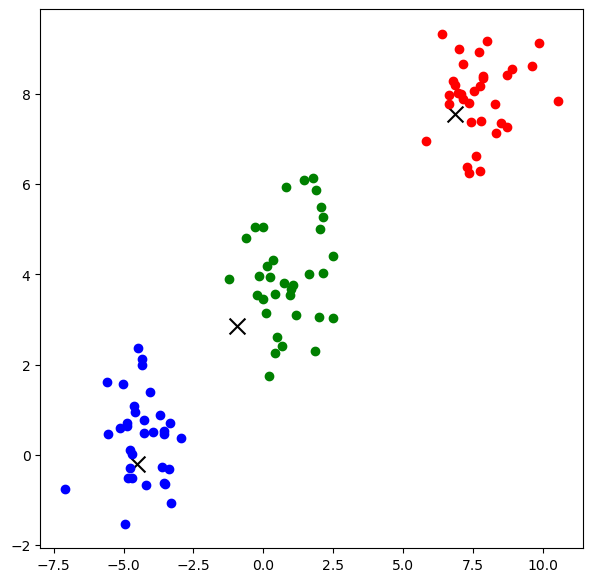

In [8]:
max_iterations = 2

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

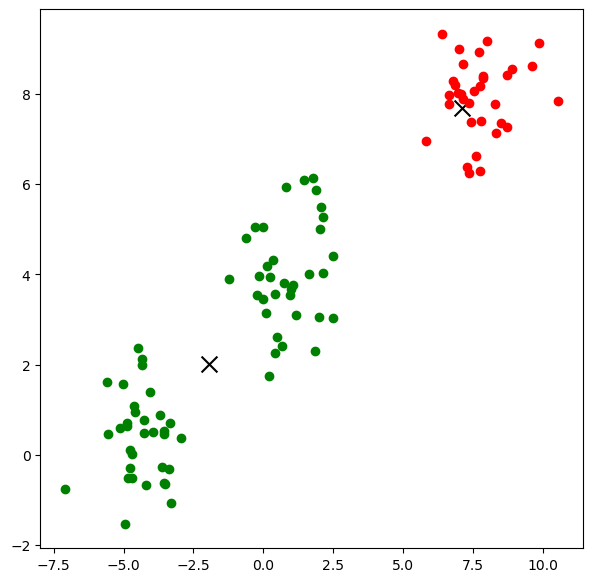

In [9]:
max_iterations = 3

centroids, clusters = kmeans(X, 2, max_iterations, min_distance)

visualize(centroids, clusters)

# Примеры решения задачи кластеризации разными методами

В модуле sklearn, одном из основных модулей, используемых для решения задач машинного обучения, по умолчанию реализовано большое количество различных методов кластерации.

Код, который [сравнивает](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html) между собой различные методы и показывает разницу представлен ниже.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [11]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples = 400, centers = 4, cluster_std = 0.60, random_state = 0)

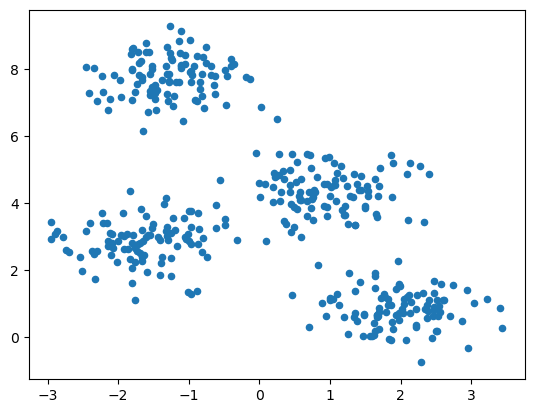

In [12]:
plt.scatter(X[:, 0], X[:, 1], s = 20);
plt.show()

In [13]:
kmeans = KMeans(n_clusters = 5)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


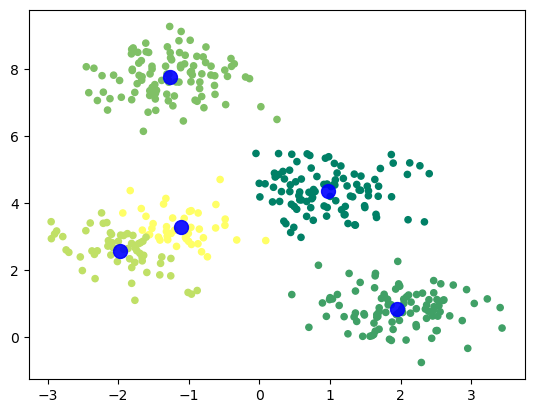

In [14]:
plt.scatter(X[:, 0], X[:, 1], c = y_kmeans, s = 20, cmap = 'summer')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'blue', s = 100, alpha = 0.9);
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_20740\130821496.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[:, 0], X[:, 1], c=c, cmap='viridis',


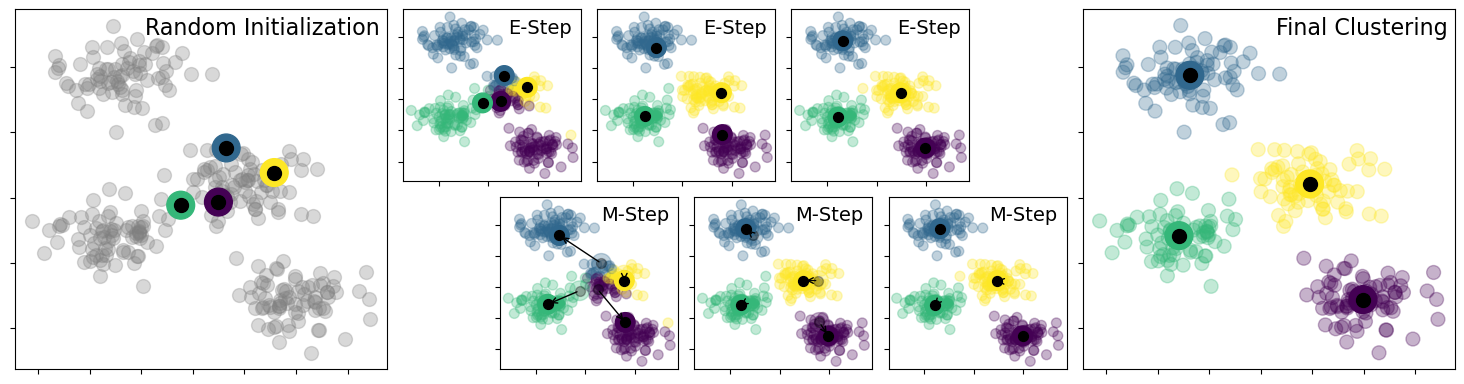

In [15]:
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances_argmin

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

rng = np.random.RandomState(42)
centers = [0, 4] + rng.randn(4, 2)

def draw_points(ax, c, factor=1):
    ax.scatter(X[:, 0], X[:, 1], c=c, cmap='viridis',
               s=50 * factor, alpha=0.3)

def draw_centers(ax, centers, factor=1, alpha=1.0):
    ax.scatter(centers[:, 0], centers[:, 1],
               c=np.arange(4), cmap='viridis', s=200 * factor,
               alpha=alpha)
    ax.scatter(centers[:, 0], centers[:, 1],
               c='black', s=50 * factor, alpha=alpha)

def make_ax(fig, gs):
    ax = fig.add_subplot(gs)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    return ax

fig = plt.figure(figsize=(15, 4))
gs = plt.GridSpec(4, 15, left=0.02, right=0.98, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)
ax0 = make_ax(fig, gs[:4, :4])
ax0.text(0.98, 0.98, "Random Initialization", transform=ax0.transAxes,
         ha='right', va='top', size=16)
draw_points(ax0, 'gray', factor=2)
draw_centers(ax0, centers, factor=2)

for i in range(3):
    ax1 = make_ax(fig, gs[:2, 4 + 2 * i:6 + 2 * i])
    ax2 = make_ax(fig, gs[2:, 5 + 2 * i:7 + 2 * i])

    # E-step
    y_pred = pairwise_distances_argmin(X, centers)
    draw_points(ax1, y_pred)
    draw_centers(ax1, centers)

    # M-step
    new_centers = np.array([X[y_pred == i].mean(0) for i in range(4)])
    draw_points(ax2, y_pred)
    draw_centers(ax2, centers, alpha=0.3)
    draw_centers(ax2, new_centers)
    for i in range(4):
        ax2.annotate('', new_centers[i], centers[i],
                     arrowprops=dict(arrowstyle='->', linewidth=1))


    # Finish iteration
    centers = new_centers
    ax1.text(0.95, 0.95, "E-Step", transform=ax1.transAxes, ha='right', va='top', size=14)
    ax2.text(0.95, 0.95, "M-Step", transform=ax2.transAxes, ha='right', va='top', size=14)


# Final E-step
y_pred = pairwise_distances_argmin(X, centers)
axf = make_ax(fig, gs[:4, -4:])
draw_points(axf, y_pred, factor=2)
draw_centers(axf, centers, factor=2)
axf.text(0.98, 0.98, "Final Clustering", transform=axf.transAxes,
         ha='right', va='top', size=16)


fig.savefig('05.11-expectation-maximization.png')

Automatically created module for IPython interactive environment


c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1848: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1848: UserWarning: Mini

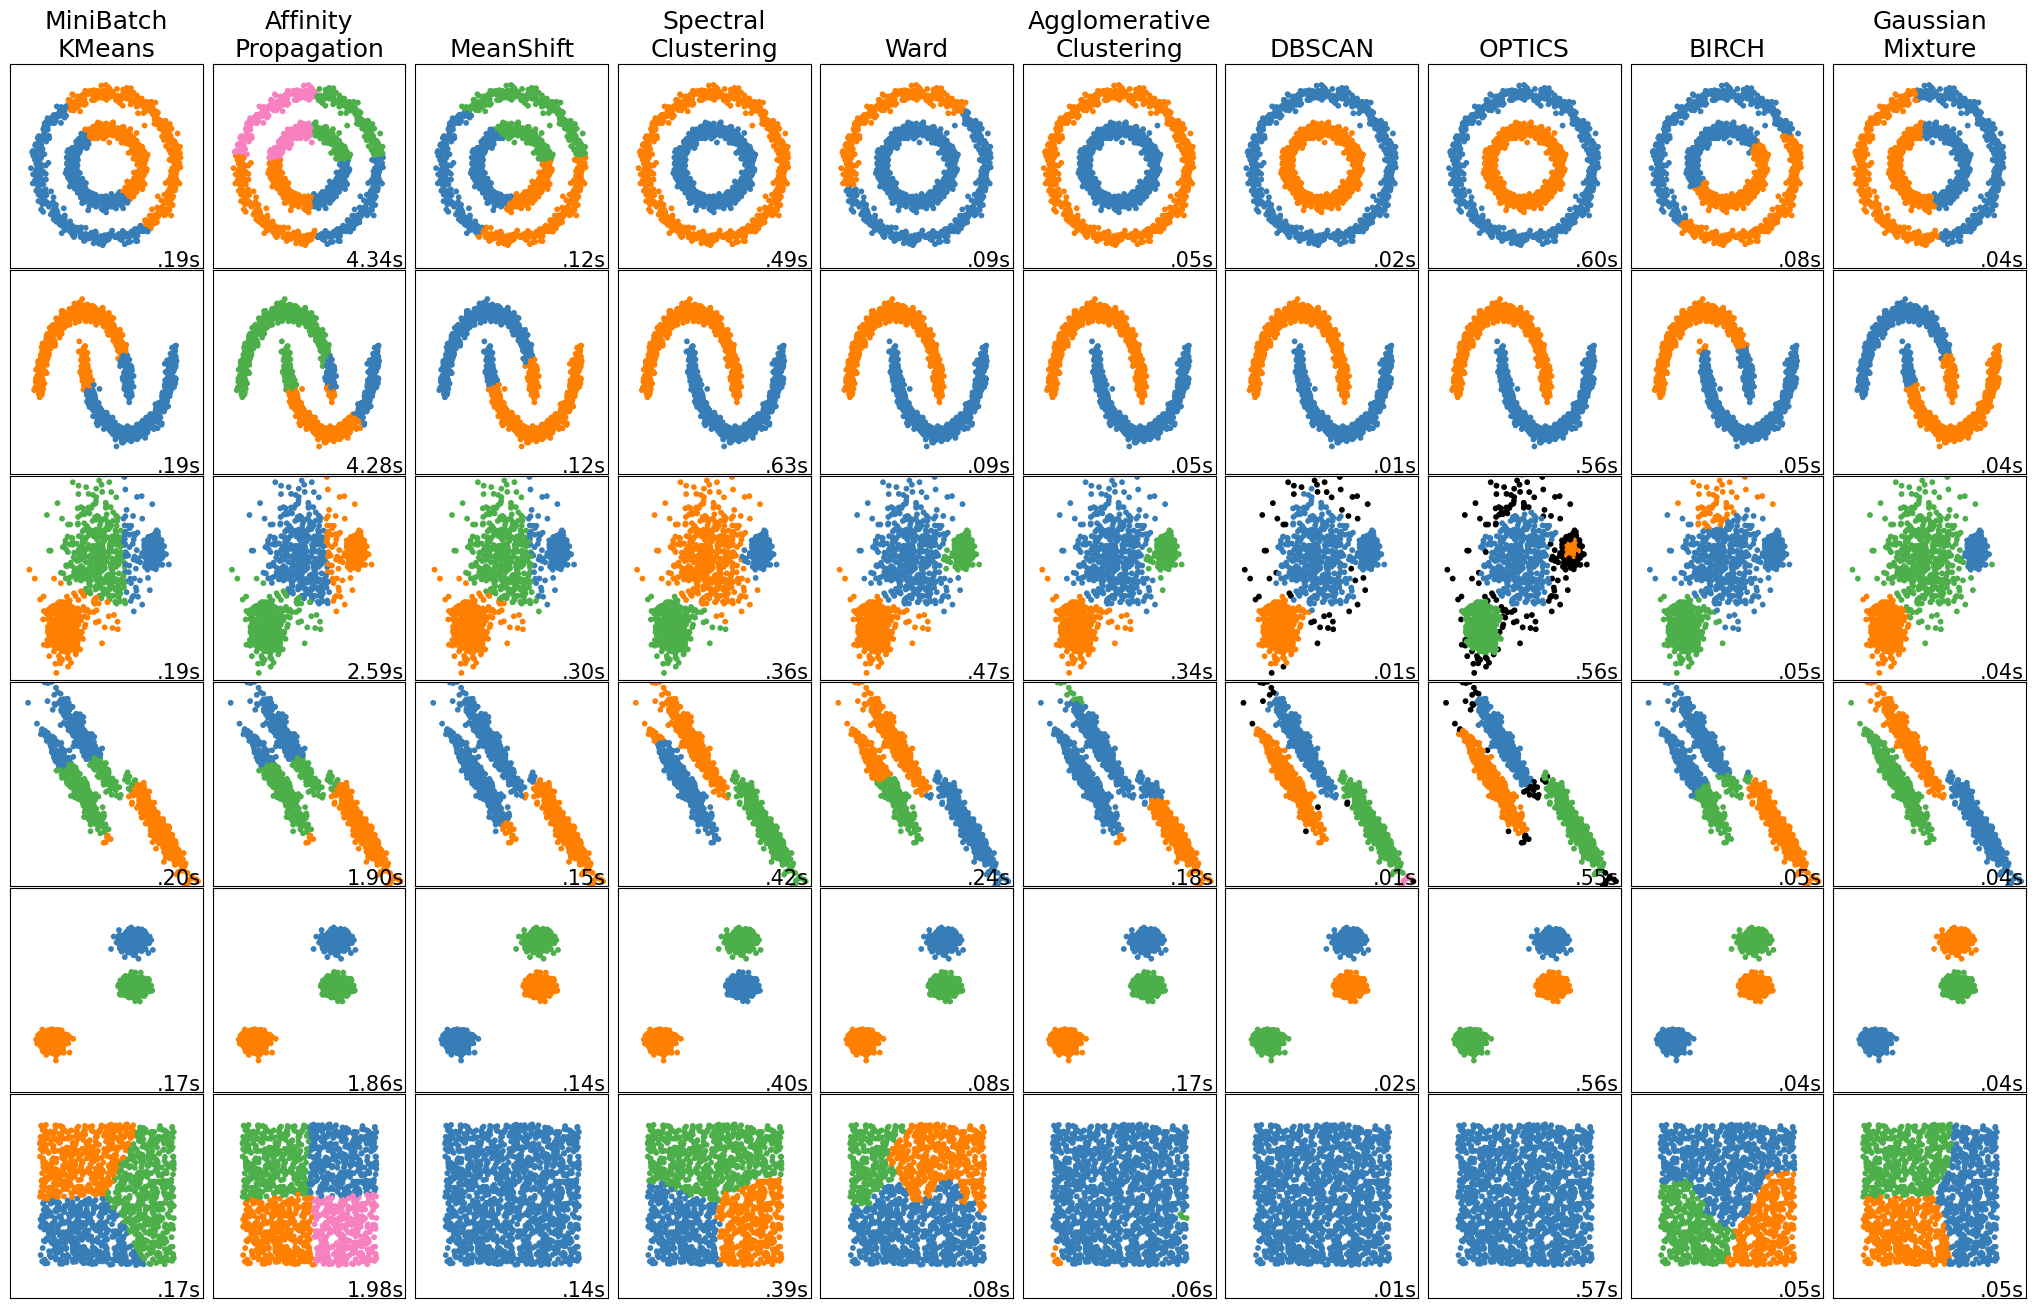

In [16]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Создание набора данных для работы (набора точек). Размер выбран так, чтобы
# можно было заметить различия в работе методов, связанные с количество признаков,
# но не настолько большим, чтобы исполнение кода длилось слишком долго.
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# СОздание распределлённых данных
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Установка параметров кластеров
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # изменение параметров на специфичные для набора данных значения
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # нормализация набора данных (мы не разбирали что это, но это важно)
    X = StandardScaler().fit_transform(X)

    # оценка ширины полосы для метода "mean shift"
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # расчёт матрицы свяжности для метода
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # симметричность
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Создание кластеров
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatch\nKMeans', two_means),
        ('Affinity\nPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('Spectral\nClustering', spectral),
        ('Ward', ward),
        ('Agglomerative\nClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('BIRCH', birch),
        ('Gaussian\nMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # работа с предупреждениям (ворнингами, warnings)
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # добавление чёрного цвета к объектам, которые были определены, как не относящиеся ни к одному кластеру
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()